In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [85]:
words = open('names.txt').read().splitlines()

In [86]:
len(words)

32033

In [89]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [92]:
#build the dataset
block_size = 3

def build_dataset(words):
    X,Y= [],[]
    for w in words:
        context = [0] * block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

In [ ]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [150]:
maxsteps = 10000
batch_size = 32
g = torch.Generator().manual_seed(42)
n_embd = 10
n_hidden = 50

C = torch.randn(vocab_size, n_embd, generator = g)
W1 = torch.randn(n_embd*block_size, n_hidden, generator = g)*(5/3)*(1/n_embd*block_size)**(-0.5) 
b1 = torch.randn(n_hidden) 
W2 = torch.randn(n_hidden, vocab_size)
b2 = torch.randn(vocab_size)
bngain = torch.ones(1,n_hidden)
bnbias = torch.zeros(1,n_hidden)
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C,W1,W2,b1,b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True


In [ ]:
for i in range(maxsteps):
    ix = torch.randint(0,len(Xtr), (32,))
    emb = C[Xtr[ix]]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat@W1 + b1
    bnmeani = hpreact.mean(0, keepdim = True)
    bnstdi = hpreact.std(0,keepdim = True)

    hpreact = (bngain*(hpreact - bnmeani))/bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h1 = torch.tanh(hpreact)
    logits = h1@W2 + b2
    loss = F.cross_entropy(logits,Ytr[ix])

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    if (i % 1000 == 0):
        print(f'{i:7d}/{maxsteps:7d}:{loss.item():.4f}')

      0/  10000:2.3075
   1000/  10000:2.2272
   2000/  10000:2.3254
   3000/  10000:2.0759
   4000/  10000:2.5878
   5000/  10000:2.7729
   6000/  10000:2.1836
   7000/  10000:2.3820
   8000/  10000:2.0584
   9000/  10000:2.1195


In [190]:
class Dog:
    def __init__(self):
        return None
    
    def __call__(self, num_dogs):
        print(num_dogs)

    def bark(self):
        i = 1
        for i in range(num_dogs):
            print("bhow")
        

In [191]:
d = Dog()

In [193]:
d(10)

10


In [195]:
d.bark(10)

bhow
bhow
bhow
bhow
bhow
bhow
bhow
bhow
bhow
bhow


In [207]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g)/(fan_in)**(-0.5)
        self.bias = torch.zeros(fan_out) if bias else None
        
    
    def __call__(self,x):
        self.out = x@self.weight
        if self.bias is not None:
            self.out = x@self.weight + self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-05, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim = True)
            xvar = x.var(0, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma*xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1- self.momentum)*self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __init__(self):
        return None
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

    

In [214]:

n_embd = 32
n_hidden = 100
vocab_size = 27
maxsteps = 100000

C = torch.randn((vocab_size,n_embd), generator=g)
layers = [
    Linear(n_embd*block_size,n_hidden, bias = False),BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,n_hidden, bias = False),BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden, vocab_size, bias = False),BatchNorm1d(vocab_size)
    ]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layers, Linear):
            layer.weight *= 5/3


parameters = [C] + [p for p in layer.parameters() for layer in layers]
for p in parameters:
    p.requires_grad = True


In [216]:
for i in range(maxsteps):
    ix = torch.randint(0, len(words), (batch_size,), generator = g)
    emb = C[Xtr[ix]]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    
    logits = x 
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i< 80000 else 0.01
    p.data += -lr*p.grad

    if (i % 10000 == 0):
        print(loss.item())


print(loss.item())



3.2983977794647217
3.285334348678589


layer 2 (      Tanh): mean -0.00, std 0.62, saturated: 3.75%
layer 5 (      Tanh): mean -0.00, std 0.63, saturated: 3.09%


Text(0.5, 1.0, 'activation distribution')

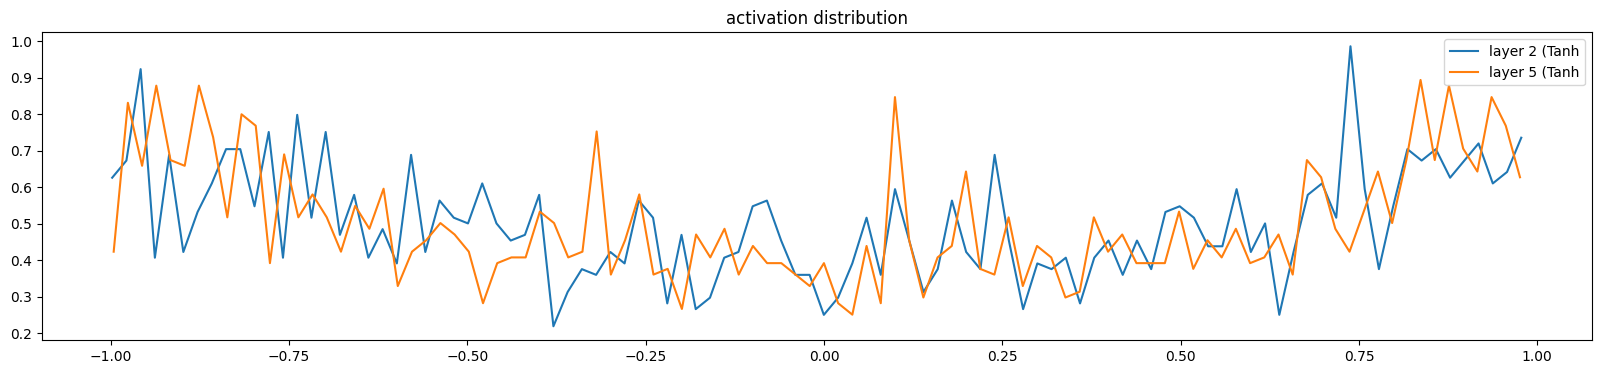

In [213]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')